<a href="https://colab.research.google.com/github/AbhinavRobinson/sentdex_tut_dl/blob/master/R_NN_Advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Lets obtaian out dataset from sentdex
!wget --no-check-certificate \
    https://pythonprogramming.net/static/downloads/machine-learning-data/crypto_data.zip \
    -O /tmp/crypto_data.zip

--2019-08-29 16:56:56--  https://pythonprogramming.net/static/downloads/machine-learning-data/crypto_data.zip
Resolving pythonprogramming.net (pythonprogramming.net)... 104.237.143.20, 2600:3c00::f03c:91ff:fe84:176d
Connecting to pythonprogramming.net (pythonprogramming.net)|104.237.143.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5998694 (5.7M) [application/zip]
Saving to: ‘/tmp/crypto_data.zip’

/tmp/crypto_data.zi 100%[===================>]   5.72M  5.21MB/s    in 1.1s    

2019-08-29 16:56:58 (5.21 MB/s) - ‘/tmp/crypto_data.zip’ saved [5998694/5998694]



In [0]:
import os
import zipfile

# This code is meant to run on google colab
local_zip = '/tmp/crypto_data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [14]:
import pandas as pd

# Lets check the data :)
main_df = pd.DataFrame()

# Lets combine all data in one dataframe
ratios = ["BTC-USD","LTC-USD","ETH-USD","BCH-USD"]
for ratio in ratios:
  dataset = f"crypto_data/{ratio}.csv"
  df = pd.read_csv(dataset,  
                   names=["time","low","high","open","close","volume"])

  df.rename(columns={"close": f"{ratio}_close", 
                     "volume": f"{ratio}_volume"}, 
            inplace=True)
  df.set_index("time",inplace=True)
  df = df[[f"{ratio}_close",f"{ratio}_volume"]]

  if len(main_df) == 0:
    main_df = df
  else:
    main_df = main_df.join(df)

# testing data
print(main_df.head())

            BTC-USD_close  BTC-USD_volume  ...  BCH-USD_close  BCH-USD_volume
time                                       ...                               
1528968660    6489.549805        0.587100  ...     871.719971        5.675361
1528968720    6487.379883        7.706374  ...     870.859985       26.856577
1528968780    6479.410156        3.088252  ...     870.099976        1.124300
1528968840    6479.410156        1.404100  ...     870.789978        1.749862
1528968900    6479.979980        0.753000  ...     870.000000        1.680500

[5 rows x 8 columns]


In [0]:
import time
# Now we define some time variables
# Based on last 60 mins
SEQ_LEN = 60
# We predict next 3
FUTURE_PERIOD_PREDICT = 3
# on the LTC-USD (LiteCoin)
RATIO_TO_PREDICT = "LTC-USD"
# Defining no. of EPOCHS
EPOCHS = 10
# Defining Batch Size
BATCH_SIZE = 64
# Adding Names
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

In [0]:
def classify(current, future):
  # aka, good thing, buy
  if float(future) > float(current): return 1
  # not a good thing, maybe? ;)
  else: return 0

In [20]:
# Lets add future price as a column
main_df['future'] = main_df[f"{RATIO_TO_PREDICT}_close"].shift(-FUTURE_PERIOD_PREDICT)
print(main_df[[f"{RATIO_TO_PREDICT}_close", "future"]].head())

            LTC-USD_close     future
time                                
1528968660      96.580002  96.500000
1528968720      96.660004  96.389999
1528968780      96.570000  96.519997
1528968840      96.500000  96.440002
1528968900      96.389999  96.470001


In [24]:
# add output of classify to a list shown as a column
main_df['target'] = list(map(classify, 
                             main_df[f"{RATIO_TO_PREDICT}_close"],
                             main_df["future"]))

print(main_df[[f"{RATIO_TO_PREDICT}_close", "future", "target"]].head(10))

            LTC-USD_close     future  target
time                                        
1528968660      96.580002  96.500000       0
1528968720      96.660004  96.389999       0
1528968780      96.570000  96.519997       0
1528968840      96.500000  96.440002       0
1528968900      96.389999  96.470001       1
1528968960      96.519997  96.400002       0
1528969020      96.440002  96.400002       0
1528969080      96.470001  96.400002       0
1528969140      96.400002  96.400002       0
1528969200      96.400002  96.400002       0


In [0]:
# Noramlly data is sorted, but just in case
# .values converts index values to numpy array
times = sorted(main_df.index.values)
# now we seperate the last 5% data for test data
# last_5pct is a unix timestamp
last_5pct = times[-int(0.05*len(times))]

# Now we split the data
validation_main_df = main_df[(main_df.index >= last_5pct)]
main_df = main_df[(main_df.index < last_5pct)]

In [0]:
# Import some more libraries ;_;
from sklearn import preprocessing
from collections import deque
import random
import numpy as np

# Preprocess DF to scale all values of diff. coins on one scale
# and add percent change
def preprocess_df(df):
  df = df.drop('future',1)

  for col in df.columns:
    if col != 'target':
      df[col] = df[col].pct_change()
      df.dropna(inplace=True)
      df[col] = preprocessing.scale(df[col].values)

  df.dropna(inplace=True)

  sequential_data = []
  prev_days = deque(maxlen = SEQ_LEN)
  print(df.head())

  for i in df.values:
    prev_days.append([n for n in i[:-1]]) 
    if len(prev_days) == SEQ_LEN:
      sequential_data.append([np.array(prev_days), i[-1]])

  random.shuffle(sequential_data)

  buys = []
  sells = []

  for seq, target, in sequential_data:
    if target == 0:
      sells.append([seq, target])
    elif target == 1:
      buys.append([seq, target])

  random.shuffle(buys)
  random.shuffle(sells)

  lower = min(len(buys), len(sells))

  # Upto 30K
  buys = buys[:lower]
  sells = sells[:lower]

  sequential_data = buys+sells
  random.shuffle(sequential_data)

  X = []
  y = []

  for seq,target in sequential_data:
    X.append(seq)
    y.append(target)

  return np.array(X), y

In [35]:
train_x , train_y = preprocess_df(main_df)
validation_x , validation_y = preprocess_df(validation_main_df)

            BTC-USD_close  BTC-USD_volume  ...  BCH-USD_volume  target
time                                       ...                        
1528969140      -0.002513       -0.078919  ...       -0.006217       0
1528969200      -0.229992        0.003410  ...       -0.005884       0
1528969260      -0.000830       -0.074039  ...       -0.006200       1
1528969320       0.116299       -0.049626  ...       -0.005898       1
1528969380       0.000937       -0.082052  ...       -0.006206       0

[5 rows x 9 columns]
            BTC-USD_close  BTC-USD_volume  ...  BCH-USD_volume  target
time                                       ...                        
1534922700       0.001843       -0.214831  ...       -0.116887       0
1534922760      -0.132096       -0.221802  ...        0.024271       0
1534922820      -0.219057       -0.272547  ...       -0.115852       0
1534922880       0.003610       -0.278621  ...       -0.116272       0
1534923180       0.003610        0.464371  ...       -0

In [36]:
print(f"train data: {len(train_x)} validation: {len(validation_x)}")
print(f"Dont Buys : {train_y.count(0)}, buys: {train_y.count(1)}")
print(f"VALIDATION Dont Buys: {validation_y.count(0)}, buys: {validation_y.count(1)}")

train data: 69188 validation: 3062
Dont Buys : 34594, buys: 34594
VALIDATION Dont Buys: 1531, buys: 1531


In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [44]:
model = Sequential()

model.add(CuDNNLSTM(128, 
                    input_shape=(train_x.shape[1:]), 
                    return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128, 
                    input_shape=(train_x.shape[1:]), 
                    return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128, input_shape=(train_x.shape[1:])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

tensorboard = TensorBoard(log_dir=f'logs/{NAME}')

filepath = "RNN_Final-{epoch:02d}-{val_acc: .3f}"
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, 
                                                      monitor= 'val_acc',
                                                      verbose=1,
                                                      save_best_only = True,
                                                      mode='max'))

history = model.fit(
    train_x, train_y,
    batch_size= BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x,validation_y),
    callbacks=[tensorboard,checkpoint]
)

Train on 69188 samples, validate on 3062 samples
Epoch 1/10
69188/69188 [==============================] - 70s 1ms/sample - loss: 0.7124 - acc: 0.5159 - val_loss: 0.6866 - val_acc: 0.5483
Epoch 2/10
69188/69188 [==============================] - 68s 982us/sample - loss: 0.6869 - acc: 0.5471 - val_loss: 0.6847 - val_acc: 0.5454
Epoch 3/10
69188/69188 [==============================] - 68s 981us/sample - loss: 0.6834 - acc: 0.5609 - val_loss: 0.6793 - val_acc: 0.5653
Epoch 4/10
69188/69188 [==============================] - 68s 981us/sample - loss: 0.6824 - acc: 0.5602 - val_loss: 0.6791 - val_acc: 0.5650
Epoch 5/10
69188/69188 [==============================] - 68s 982us/sample - loss: 0.6811 - acc: 0.5638 - val_loss: 0.6763 - val_acc: 0.5604
Epoch 6/10
69188/69188 [==============================] - 68s 981us/sample - loss: 0.6796 - acc: 0.5690 - val_loss: 0.6883 - val_acc: 0.5490
Epoch 7/10
69188/69188 [==============================] - 68s 980us/sample - loss: 0.6784 - acc: 0.5706 - v

In [0]:
!mkdir models

In [0]:
# We import matplotlib and create a function to plot history
import matplotlib.pyplot as plt

def plot_history(histories, key='acc'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

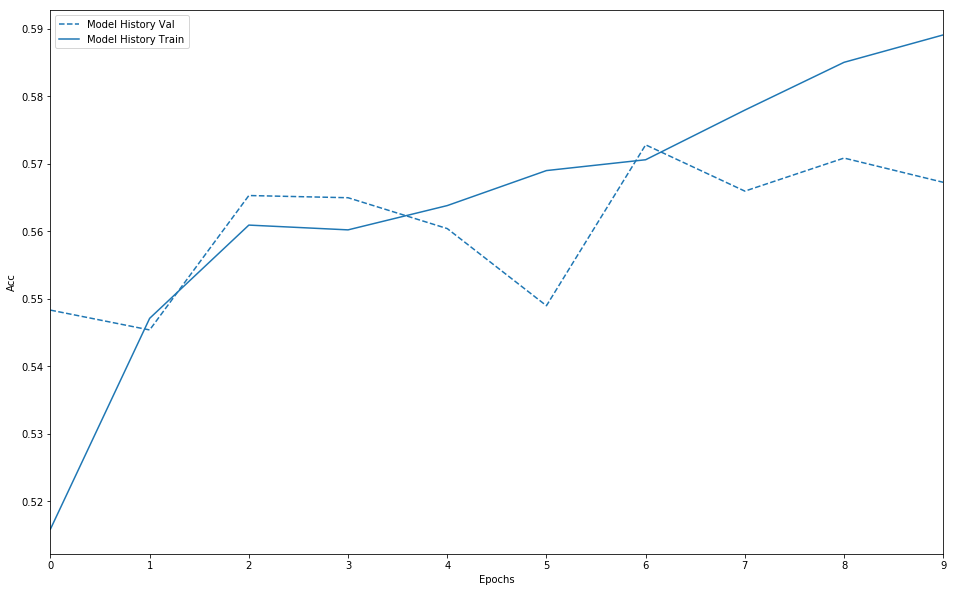

In [52]:
plot_history([('Model History',history)])

In [0]:
# This Model is for Educational Use Only.
# Dont bet on the basis of this.
# KTHXBYE.
#         -- Abhinav Robinson ;)